# House sales predictions

## Introduction

In this lab the objective is to predict the price of a house based on its features. We have some training data containing 79 features excluding the Id and sales price. And some test data containg those same features but not the sales price. To predict the values of these test houses we have to make some models, that use these supplied features and turns them into a prediction of the value. Before we can start the prediction, we first need to explore the data for features correlating to the price, and abnormalities that may interfare with our predictions. Then we need to enginer our own features to increase the accuracy of our model. Finaly we need to choose the model for our prediction.

## Table of content
1. [Cleaning the data](#first-bullet)

2. [Data Exploration](#second-bullet)
    
    2.1 [Finding feature relations](#third-bullet)
    
    2.2 [Lets plot some features](#fourth-bullet)

## Short summary

## Imports

In [367]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import lightgbm as lgb
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso , BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
import matplotlib.ticker as ticker

pd.set_option('display.max_columns', None)
base = "./challenge_data/"

## Reading the data

In [377]:
# loading the data
houseDataDF = pd.read_csv(base + "train2.csv")
idColl = houseDataDF.Id
houseDataDF = houseDataDF.drop(["Id"],axis=1)
houseDataDF.index = idColl
trainSetLength = len(houseDataDF.values)
print(houseDataDF.shape)
testDF = pd.read_csv(base + "test2.csv")
idColl = testDF.Id
testDF = testDF.drop(["Id"],axis=1)
testDF.index = idColl
print(testDF.shape)

(1460, 80)
(1459, 79)


# Data Exploration

Lets first see how many of the values in data than are empty, None or NAN.

Text(0.5,1,'Percent missing data by feature (training data)')

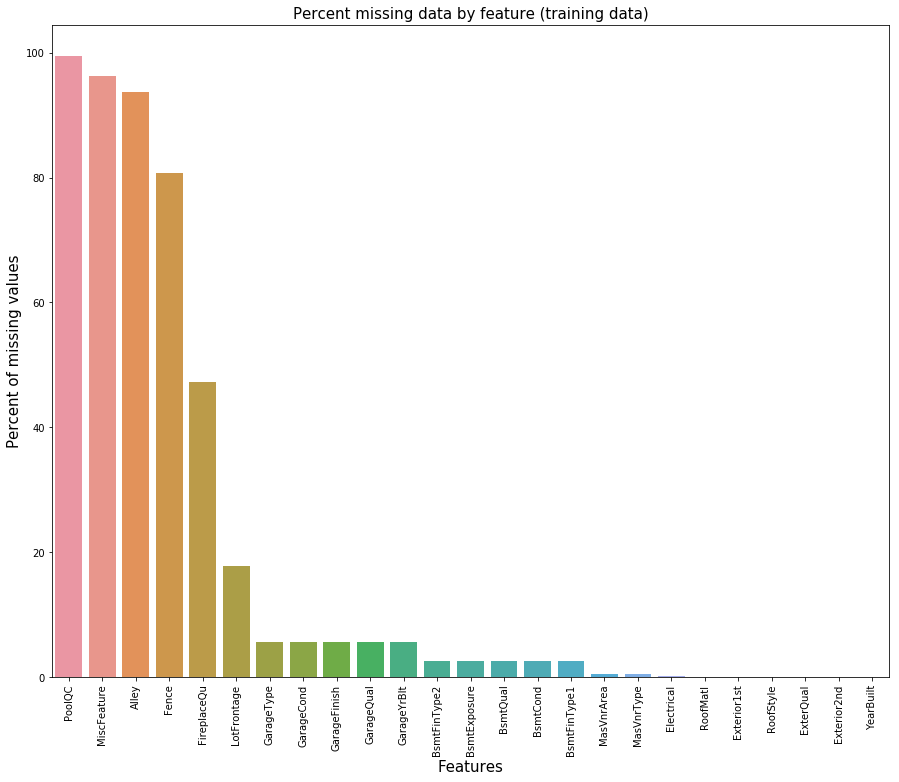

In [274]:
nulls = pd.DataFrame(houseDataDF.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=list(nulls.index), y=nulls.values.ravel() * 100 /len(houseDataDF.values))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature (training data)', fontsize=15)

We can see from the plot above that for several features for the training data, over 80% of the values are missing. Lets see if the same applies for the test data.

Text(0.5,1,'Percent missing data by feature (test data)')

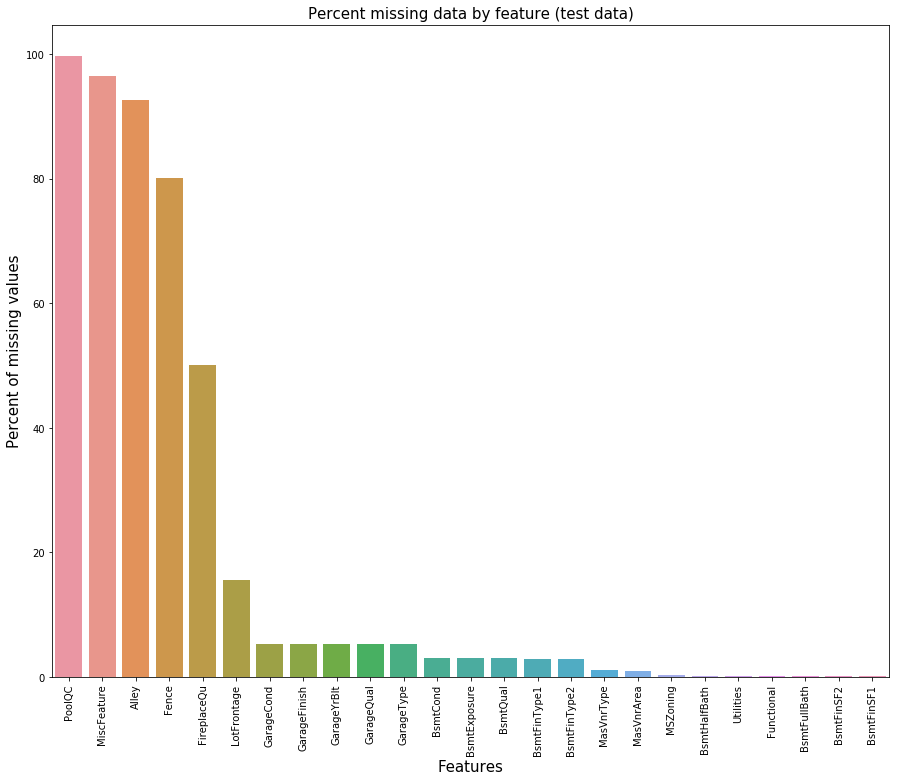

In [275]:
nulls = pd.DataFrame(testDF.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=list(nulls.index), y=nulls.values.ravel() * 100 /len(testDF.values))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature (test data)', fontsize=15)

We can see that the percentage of missing values are almost the same for test data as the training data. This is god news, as our predictions are not going to be biased by missing values.

Our data consists of both numerical and caterical features. For making predictions we need to see how these values are distributed. Lets first look at the numerical features from the training data.

In [276]:
categoricals = houseDataDF.select_dtypes(include=[np.number])
categoricals.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [277]:
categoricals = houseDataDF.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [278]:
categoricals = testDF.select_dtypes(include=[np.number])
categoricals.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [279]:
categoricals = testDF.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1459,107,1459,1459,1457,1459,1459,1459,1459,1459,1459,1459,1459,1459,1458,1458,1443,1459,1459,1459,1415,1414,1415,1417,1417,1459,1459,1459,1459,1458,1457,729,1383,1381,1381,1381,1459,3,290,51,1458,1459
unique,5,2,2,4,4,1,5,3,25,9,5,5,7,6,4,13,15,4,4,5,6,4,4,4,6,6,4,5,2,4,4,7,5,6,3,4,5,3,2,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,1114,1453,70,934,1311,1457,1081,1396,218,1251,1444,1205,745,1169,1442,510,510,878,892,1256,661,634,1295,951,431,1237,1446,752,1358,1337,757,1357,364,853,625,1293,1328,1301,2,172,46,1258,1204


## Finding feature relations

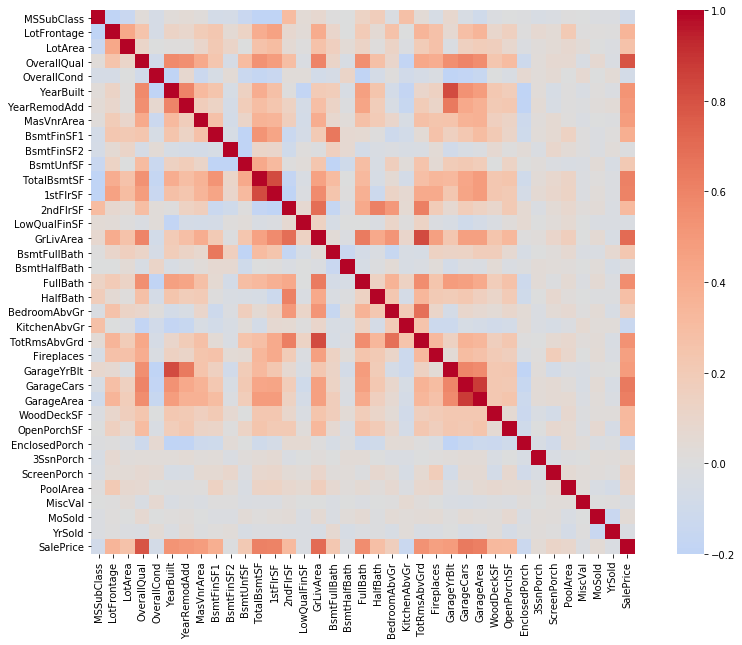

In [280]:
plt.figure(figsize=(15,10))
corr = houseDataDF.corr()


sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=-0.2, square=True, center=0,cmap='coolwarm'
           )

In [376]:

corrAsList = list(zip(corr.tail(1).values[0],list(corr)))

sortedCorr = sorted(corrAsList,key=lambda x : x[0],reverse=True)

corrDF = pd.DataFrame(data=np.array(sortedCorr),columns=["Correlation","Feature"])
print(corrDF)

highestCorrFeatures = corrDF["Feature"].values[1:11]


              Correlation        Feature
0                     1.0      SalePrice
1      0.7909816005838047    OverallQual
2      0.7086244776126511      GrLivArea
3       0.640409197258349     GarageCars
4      0.6234314389183598     GarageArea
5      0.6135805515591944    TotalBsmtSF
6      0.6058521846919166       1stFlrSF
7      0.5606637627484452       FullBath
8      0.5337231555820238   TotRmsAbvGrd
9      0.5228973328794967      YearBuilt
10     0.5071009671113867   YearRemodAdd
11    0.48636167748786213    GarageYrBlt
12     0.4774930470957107     MasVnrArea
13     0.4669288367515242     Fireplaces
14    0.38641980624215627     BsmtFinSF1
15    0.35179909657067854    LotFrontage
16    0.32441344456813076     WoodDeckSF
17    0.31933380283206614       2ndFlrSF
18    0.31585622711605577    OpenPorchSF
19     0.2841076755947784       HalfBath
20     0.2638433538714063        LotArea
21    0.22712223313149718   BsmtFullBath
22      0.214479105546969      BsmtUnfSF
23     0.1682131

## Lets plot some features

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

/home/marius/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

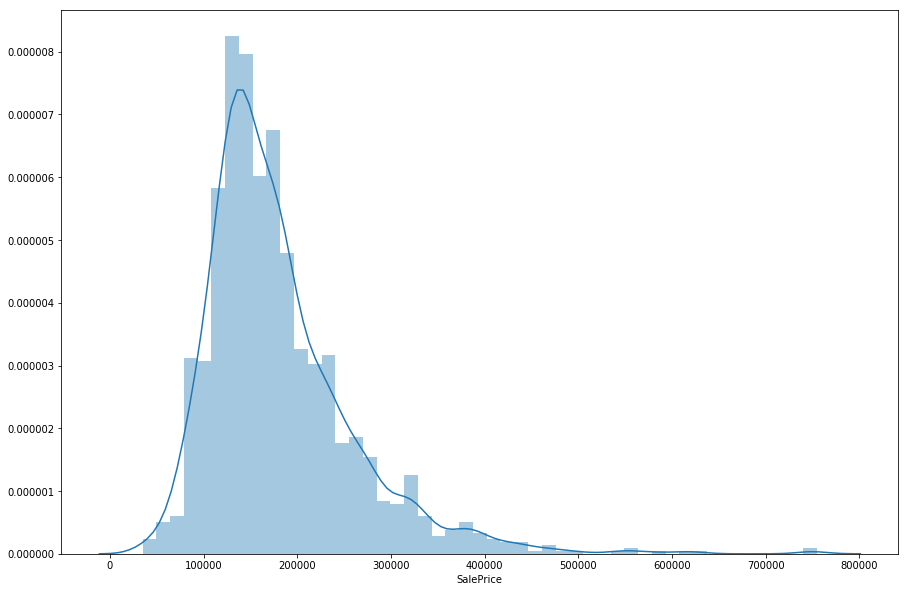

In [282]:
plt.figure(figsize=(15,10))
sns.distplot(houseDataDF.SalePrice)
houseDataDF.SalePrice.describe()

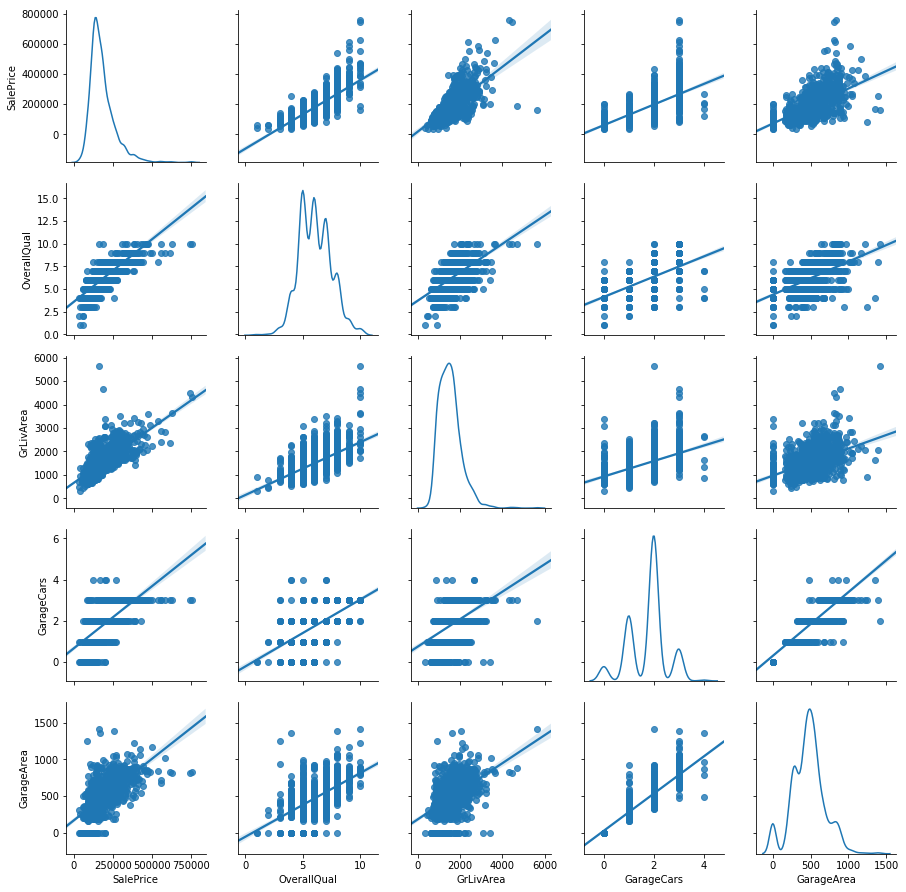

In [283]:
sns.pairplot(houseDataDF[corrDF["Feature"].values[:5]],kind="reg",diag_kind="kde")

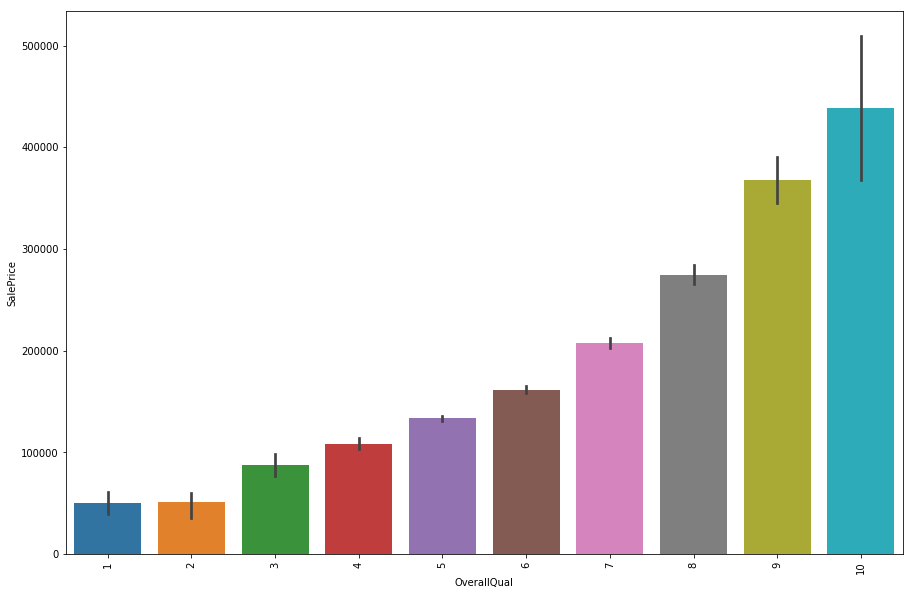

In [284]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="OverallQual", y="SalePrice", data=houseDataDF)

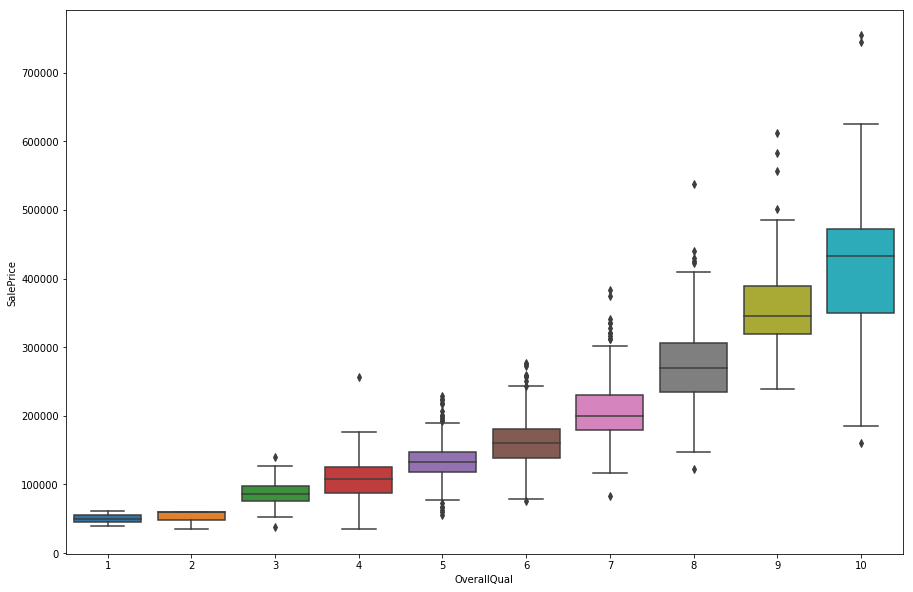

In [285]:
plt.figure(figsize=(15,10))
sns.boxplot(x='OverallQual',
               y='SalePrice', 
               data=houseDataDF)


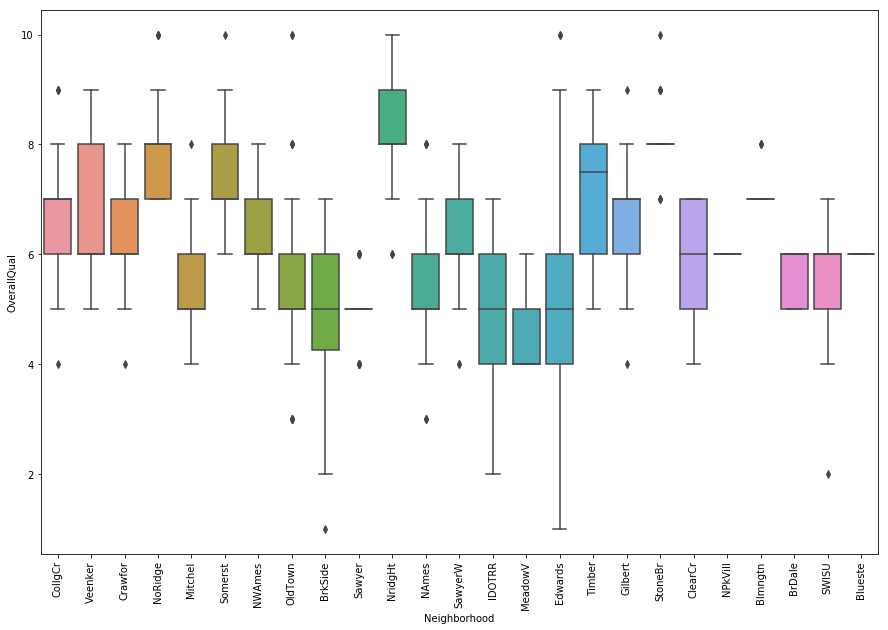

In [286]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.boxplot(x='Neighborhood',
               y='OverallQual', 
               data=houseDataDF)

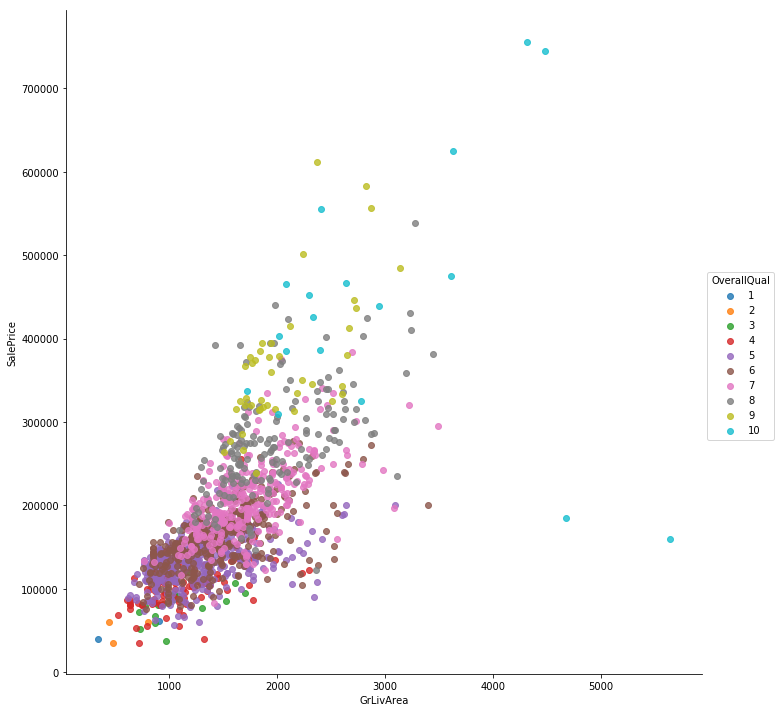

In [288]:
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataDF,fit_reg=False,size=10,hue="OverallQual") 

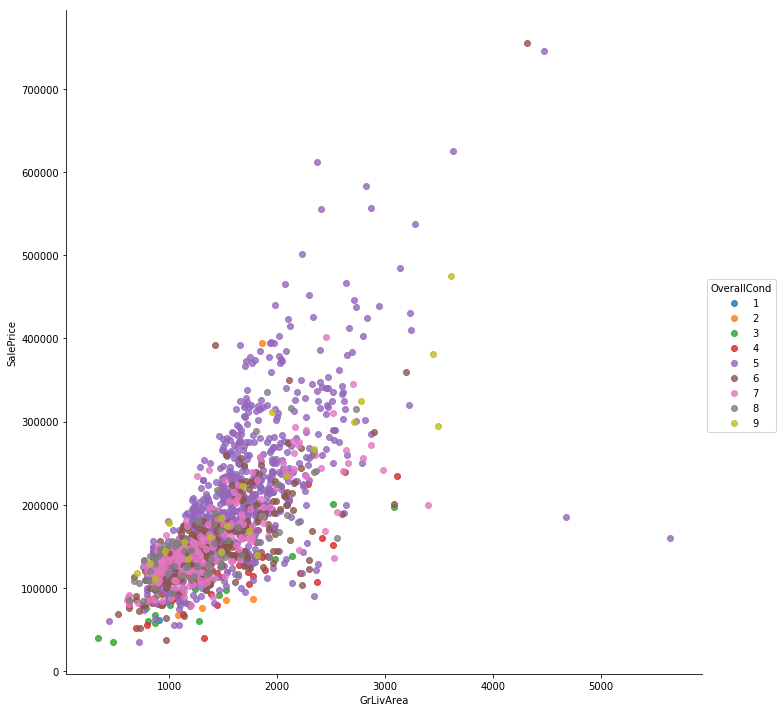

In [289]:
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataDF,fit_reg=False,size=10,hue="OverallCond") 

In [290]:
res = houseDataDF.query('SalePrice <= 200000 & OverallQual == 10 ')[highestCorrFeatures]
outliers = res.index.values
res

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
Id,,,,,,,,,,
524,10,4676,3,884,3138,3138,3,11,2007,2008
1299,10,5642,2,1418,6110,4692,2,12,2008,2008


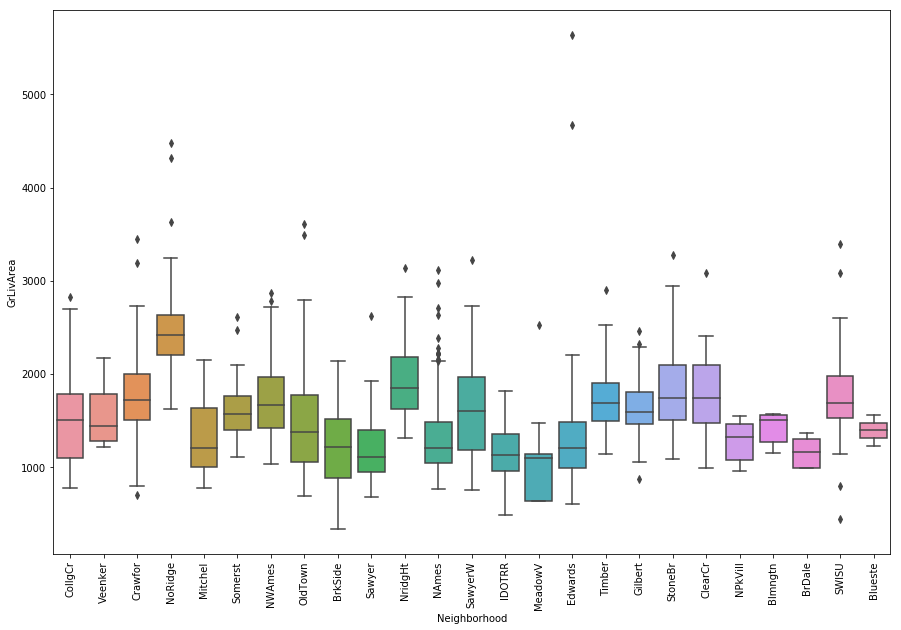

In [291]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.boxplot(x='Neighborhood',
               y='GrLivArea', 
               data=houseDataDF)

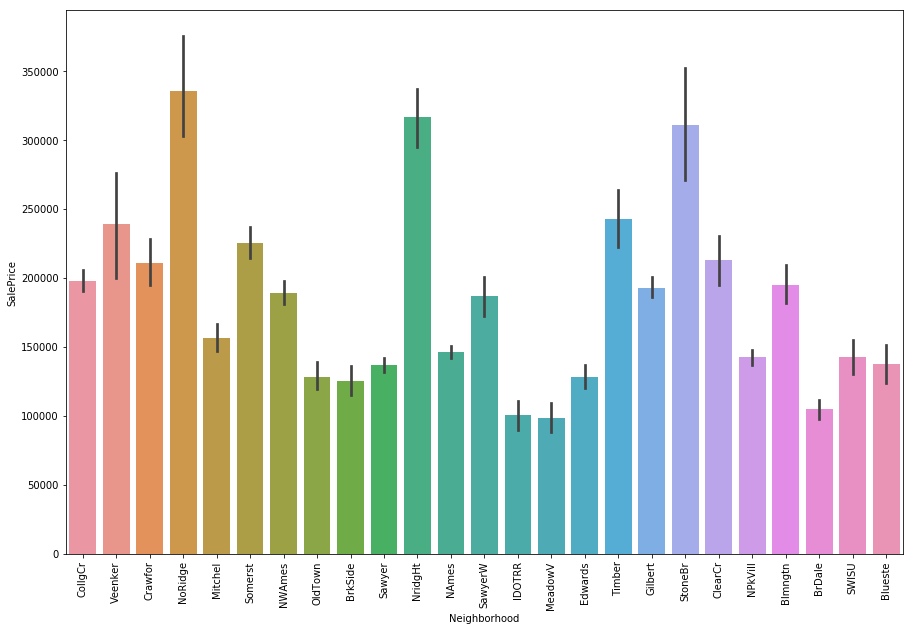

In [292]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Neighborhood", y="SalePrice", data=houseDataDF)

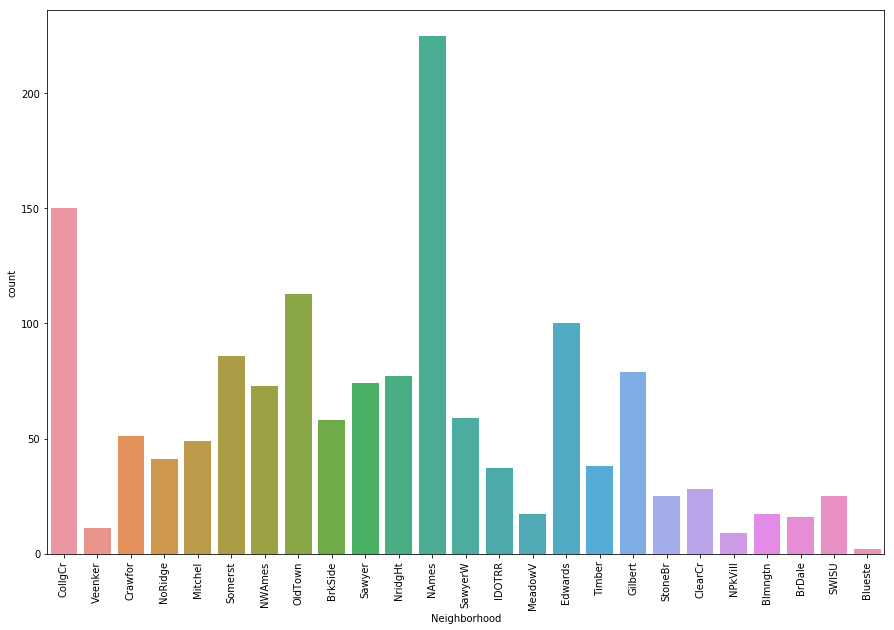

In [293]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.countplot(x="Neighborhood", data=houseDataDF)

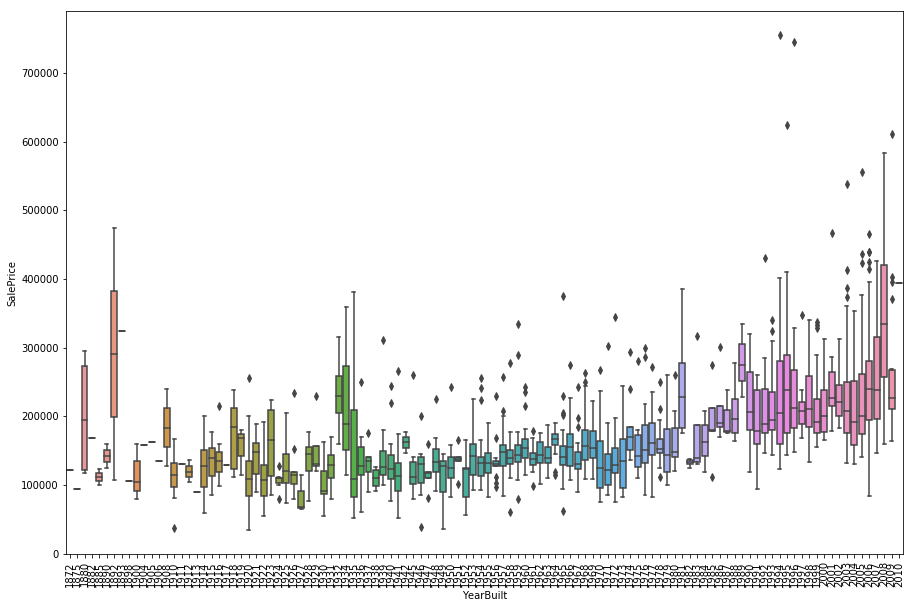

In [369]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
ax = sns.boxplot(x='YearBuilt',
               y='SalePrice', 
               data=houseDataDF)


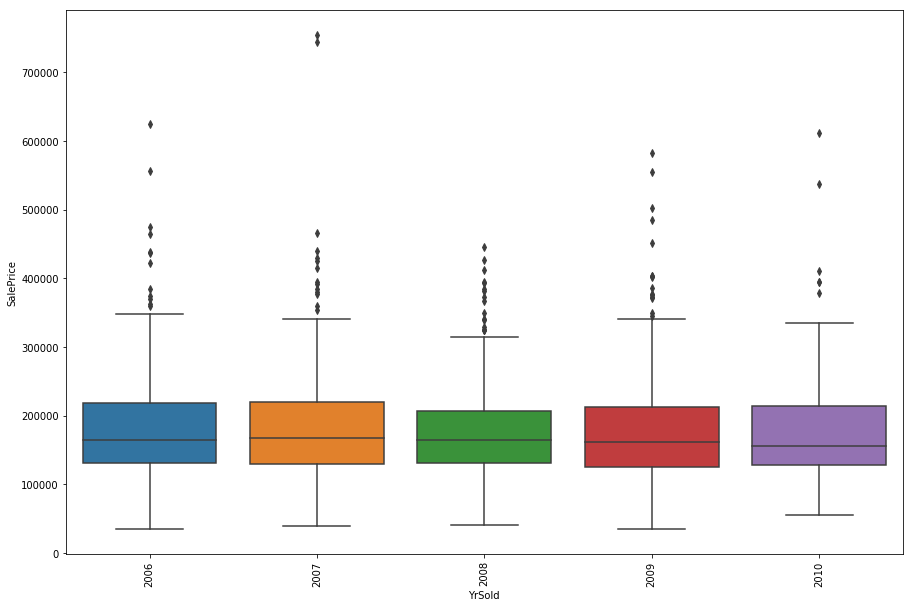

In [365]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.boxplot(x='YrSold',
               y='SalePrice', 
               data=houseDataDF)

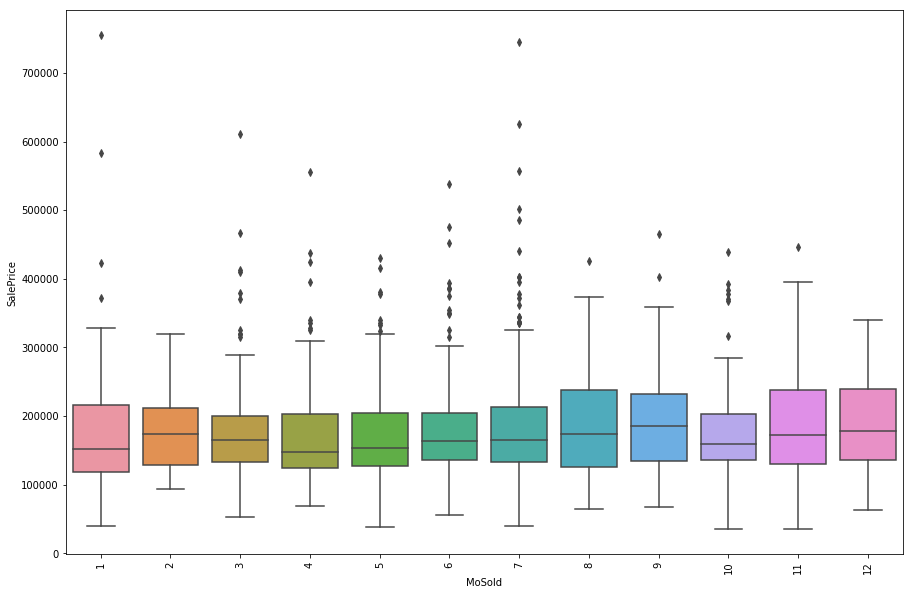

In [370]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.boxplot(x='MoSold',
               y='SalePrice', 
               data=houseDataDF)

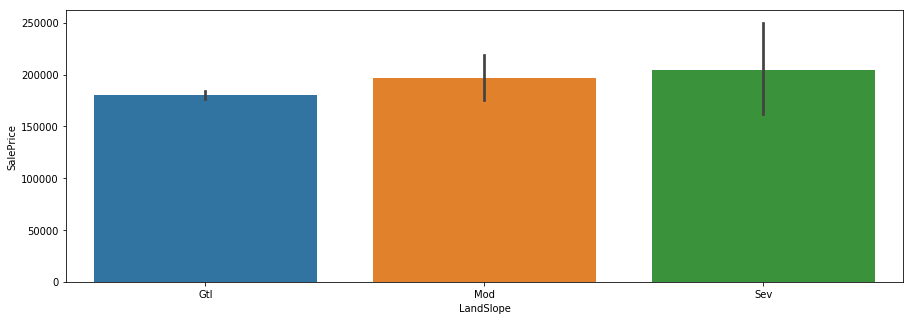

In [294]:
plt.figure(figsize=(15,5))
sns.barplot(x="LandSlope", y="SalePrice", data=houseDataDF)

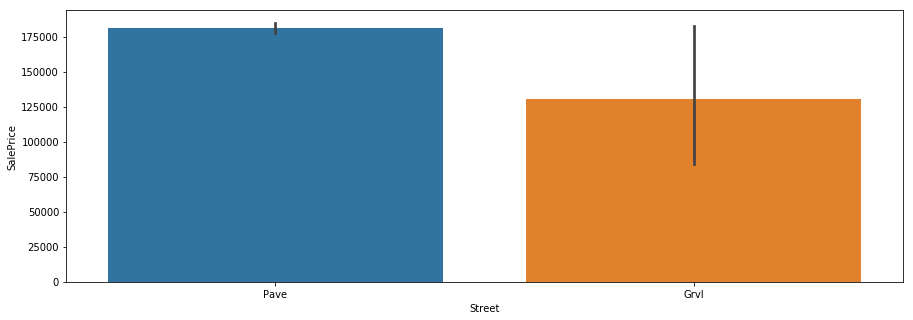

In [295]:
plt.figure(figsize=(15,5))
sns.barplot(x="Street", y="SalePrice", data=houseDataDF)

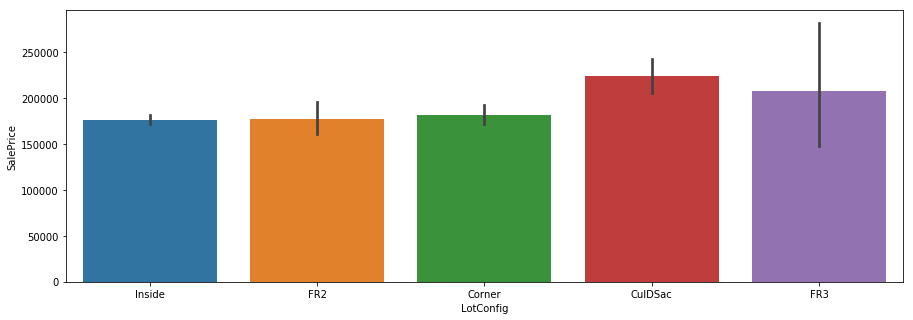

In [296]:
plt.figure(figsize=(15,5))
sns.barplot(x="LotConfig", y="SalePrice", data=houseDataDF)

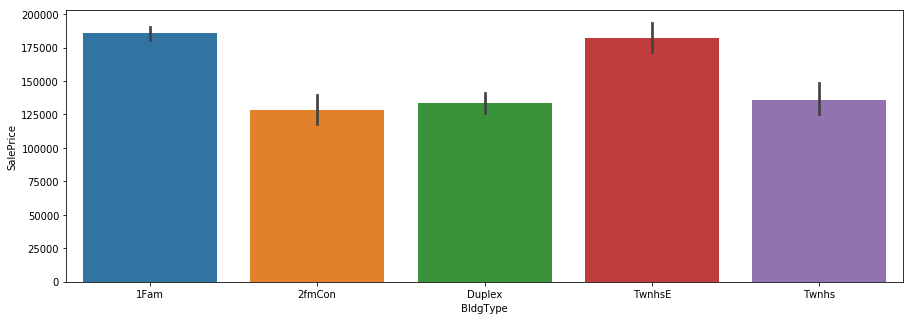

In [297]:
plt.figure(figsize=(15,5))
sns.barplot(x="BldgType", y="SalePrice", data=houseDataDF)

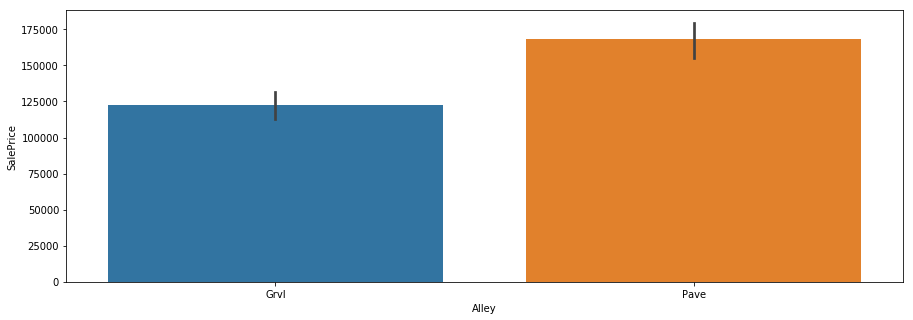

In [298]:
plt.figure(figsize=(15,5))
sns.barplot(x="Alley", y="SalePrice", data=houseDataDF)

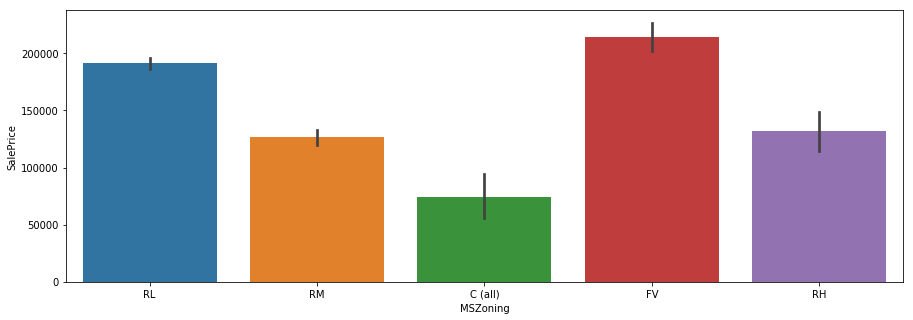

In [299]:
plt.figure(figsize=(15,5))
sns.barplot(x="MSZoning", y="SalePrice", data=houseDataDF)

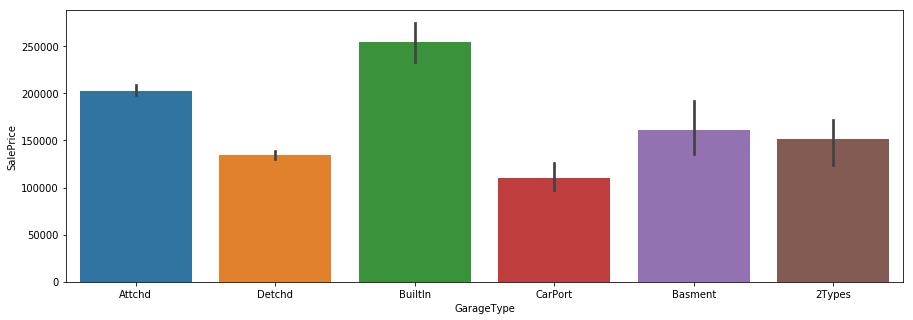

In [300]:
plt.figure(figsize=(15,5))
sns.barplot(x="GarageType", y="SalePrice", data=houseDataDF)

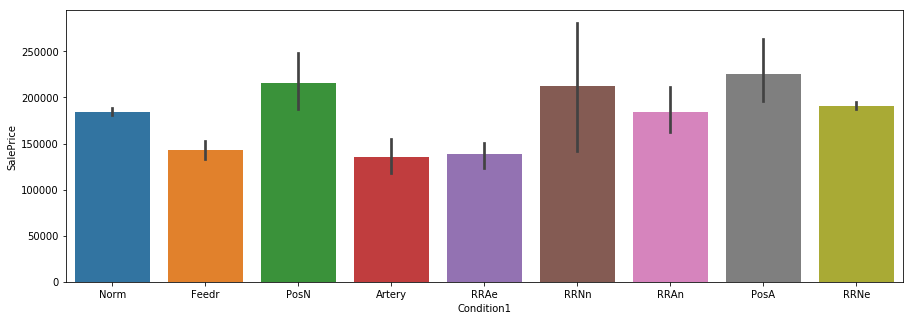

In [301]:
plt.figure(figsize=(15,5))
sns.barplot(x="Condition1", y="SalePrice", data=houseDataDF)

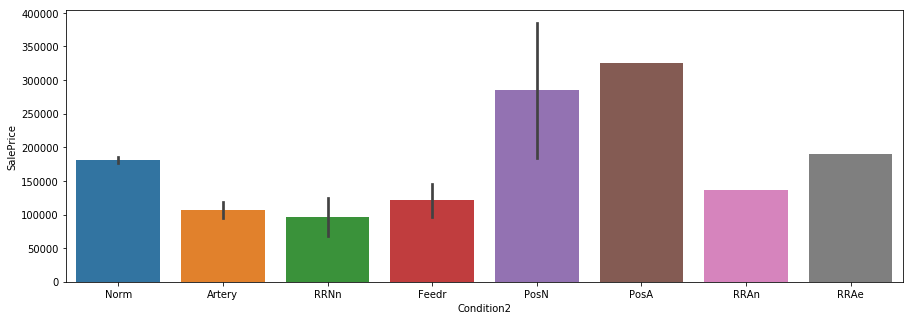

In [302]:
plt.figure(figsize=(15,5))
sns.barplot(x="Condition2", y="SalePrice", data=houseDataDF)

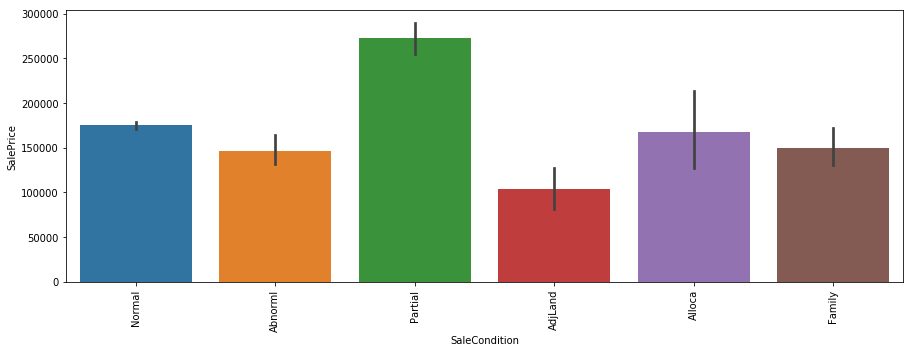

In [303]:
plt.figure(figsize=(15,5))
plt.xticks(rotation='90')
sns.barplot(x="SaleCondition", y="SalePrice", data=houseDataDF)

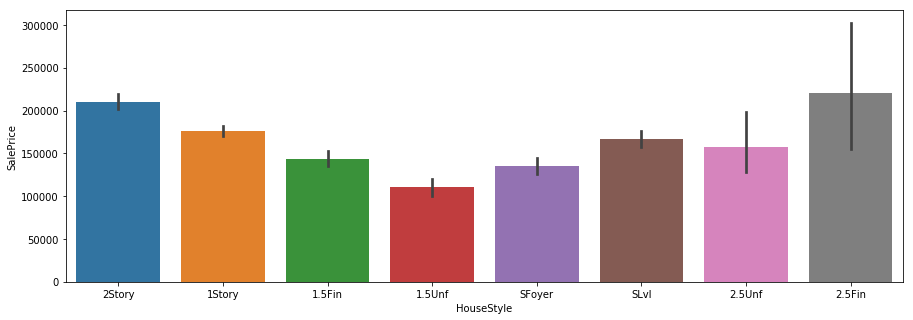

In [304]:
plt.figure(figsize=(15,5))
sns.barplot(x="HouseStyle", y="SalePrice", data=houseDataDF)

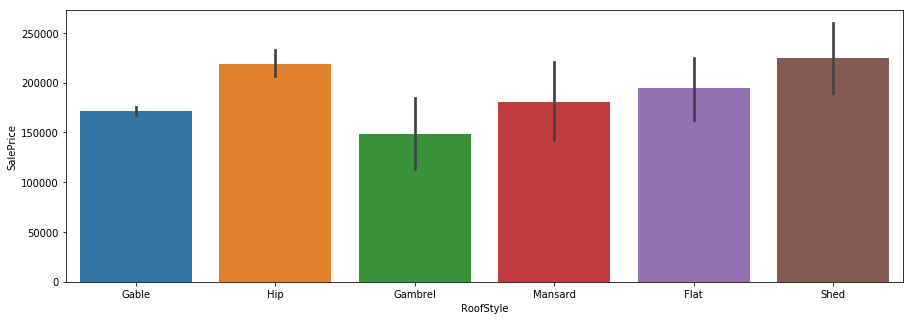

In [305]:
plt.figure(figsize=(15,5))
sns.barplot(x="RoofStyle", y="SalePrice", data=houseDataDF)

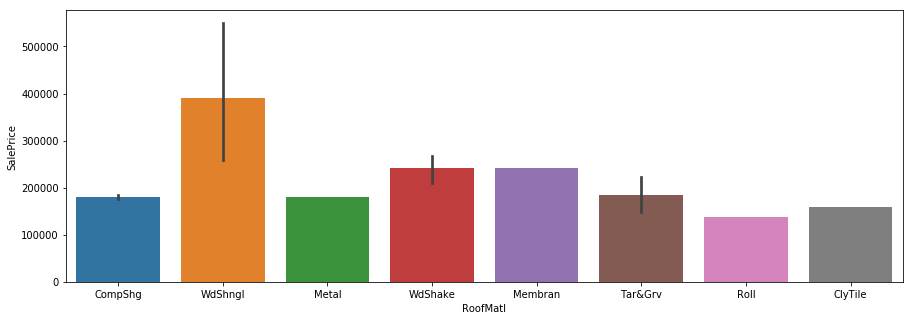

In [306]:
plt.figure(figsize=(15,5))
sns.barplot(x="RoofMatl", y="SalePrice", data=houseDataDF)

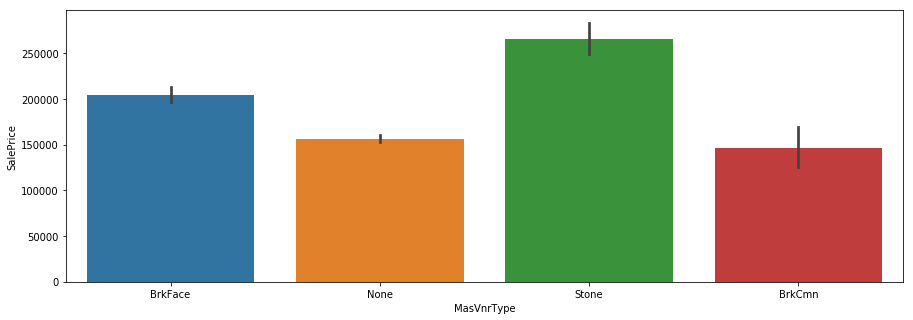

In [307]:
plt.figure(figsize=(15,5))
sns.barplot(x="MasVnrType", y="SalePrice", data=houseDataDF)

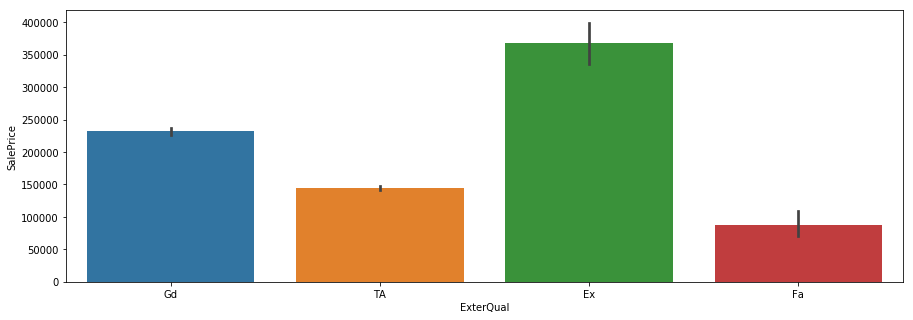

In [308]:
plt.figure(figsize=(15,5))
sns.barplot(x="ExterQual", y="SalePrice", data=houseDataDF)

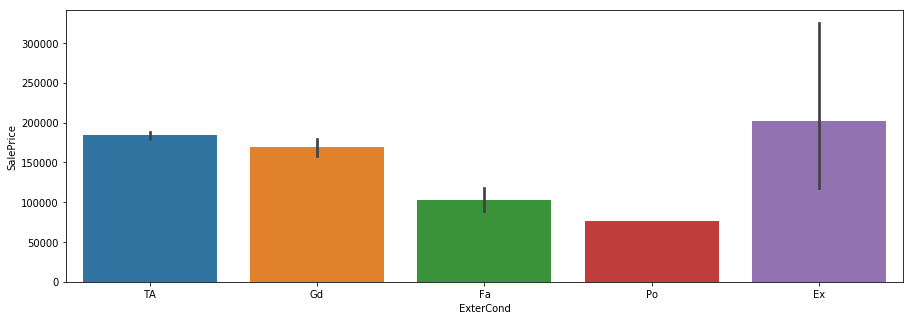

In [309]:
plt.figure(figsize=(15,5))
sns.barplot(x="ExterCond", y="SalePrice", data=houseDataDF)

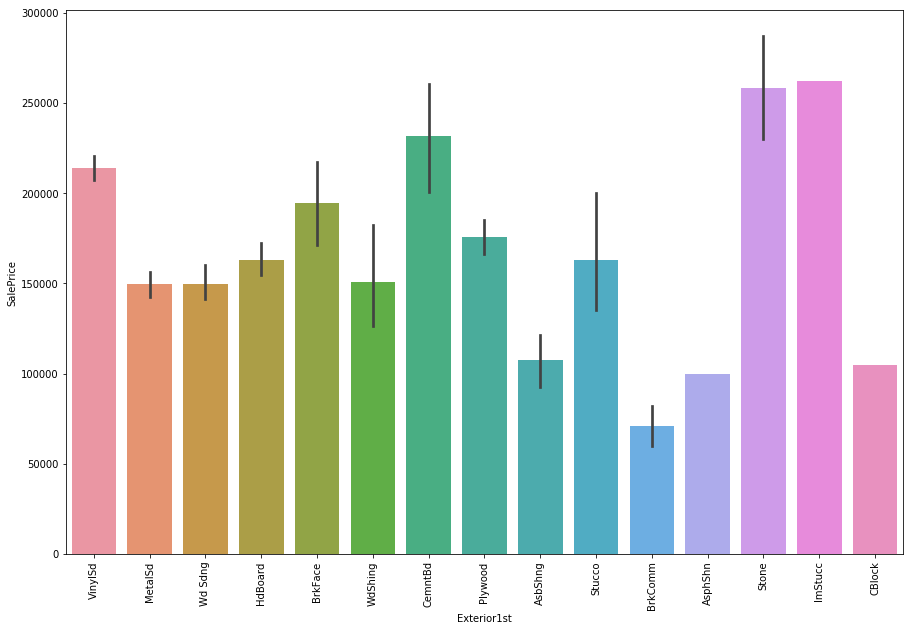

In [310]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Exterior1st", y="SalePrice", data=houseDataDF)

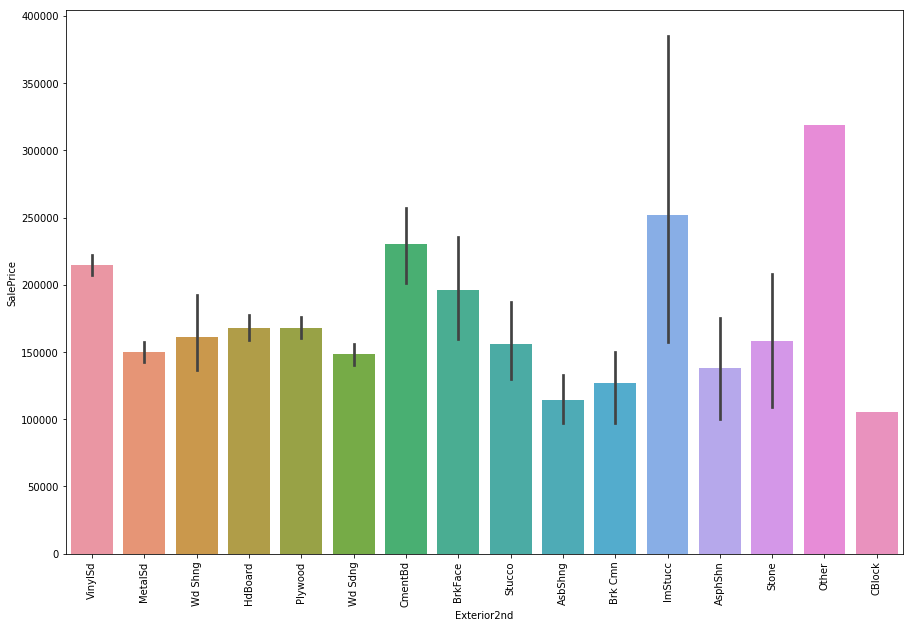

In [311]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Exterior2nd", y="SalePrice", data=houseDataDF)

# Cleaning the data

## Removing outliers

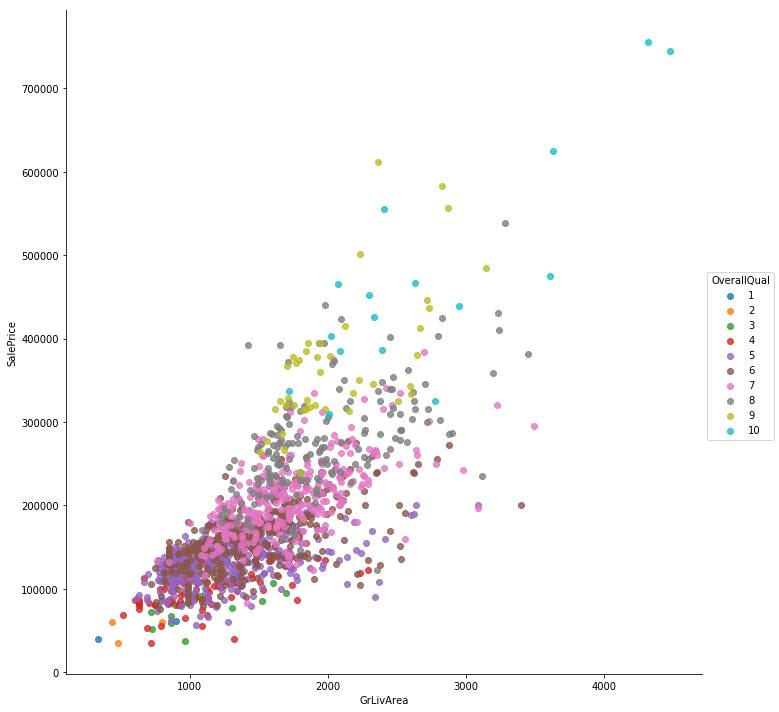

In [312]:
houseDataCleanedDF = houseDataDF.drop(outliers)
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataCleanedDF,fit_reg=False,size=10,hue="OverallQual")

## Feature engineering

In [313]:
y = np.log(houseDataCleanedDF.SalePrice)
houseDataCleanedDF = houseDataCleanedDF.drop(["SalePrice"],axis=1)
houseDataCleanedDF = pd.concat([houseDataCleanedDF,testDF])

In [375]:
def makeFeatures(houseDataDF):
    categorical_feats = houseDataDF.dtypes[houseDataDF.dtypes == "object"].index.values

    for feat in categorical_feats:
        if(feat == "Utilities"):
            continue
            
        dummies = pd.get_dummies(houseDataDF[feat], drop_first=True)
        num_categories = len(dummies.columns)
        houseDataDF[[feat+str(i) for i in range(num_categories)]] = dummies
    
    
    # CUSTOM FEATURES
    houseDataDF['NearPark'] = [1 if x=='PosN' or x=='PosA' or y=='PosN' or y=='PosA' else 0\
        for x,y in zip(houseDataDF['Condition1'],houseDataDF['Condition2'])]

    houseDataDF['Loudness'] = [1 if x=='Feedr' or x=='Artery' or x=='RRAe' or y=='Feedr'\
        or y=='Artery' or y=='RRAe' else 0 for x,y in zip(houseDataDF['Condition1'],houseDataDF['Condition2'])]
    
    houseDataDF['TotalSF'] = houseDataDF['TotalBsmtSF'] + houseDataDF['1stFlrSF'] + houseDataDF['2ndFlrSF']
    
    houseDataDF['TimeBetweenRemodAndBuild'] =  [x-y for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    
    houseDataDF['RemodeledResent'] =  [1 if x != y and 2010 - x < 10 else 0 for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    
    houseDataDF['Age'] =  [2010 - x for x in houseDataDF["YearBuilt"]]
    
    houseDataDF['AvgQualCond'] =  [(int(x)+int(y))/2 for x,y in zip(houseDataDF["OverallQual"],houseDataDF["OverallCond"])]
    
    houseDataDF['TotalPorchSF'] = houseDataDF['OpenPorchSF'] + houseDataDF['EnclosedPorch'] + houseDataDF['3SsnPorch'] + houseDataDF['ScreenPorch']
    
    houseDataDF['OverallQualSquared'] = [x**2 for x in houseDataDF["OverallQual"]]
    
    houseDataDF['OverallCondSquared'] = [x**2 for x in houseDataDF["OverallCond"]]
    
    houseDataDF['avgQualCondSquared'] = [x**2 for x in houseDataDF["AvgQualCond"]]
    
    return houseDataDF


houseDataCleanedDF = makeFeatures(houseDataCleanedDF)
# TODO : Add feature for centrality

## Fixing skew

In [315]:
def fixSkew(houseDataDF):
    numeric_feats = houseDataDF.dtypes[houseDataDF.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = houseDataDF[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


    skewed_features = skewness.index

    lam = 0.15
    for feat in skewed_features:
        #all_data[feat] += 1
        if(feat not in ["SalePrice","YearBuilt"]):
            houseDataDF[feat] = boxcox1p(houseDataDF[feat], lam)
    return houseDataDF

houseDataCleanedDF = fixSkew(houseDataCleanedDF)


Skew in numerical features: 

There are 255 skewed numerical features to Box Cox transform


# Predictions

https://datascienceplus.com/linear-regression-in-python-predict-the-bay-areas-home-prices/
https://www.kaggle.com/dougdaly/house-price-modeling-with-random-forest-regressors
https://shankarmsy.github.io/stories/gbrt-sklearn.html
https://www.kaggle.com/nolberg/machine-learning-for-house-price-prediction
https://kaggle2.blob.core.windows.net/forum-message-attachments/216792/7200/MDSSKaggle_Slides_Henry.pdf
https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
https://www.kaggle.com/jimthompson/ensemble-model-stacked-model-example
https://www.kaggle.com/janiobachmann/in-depth-analysis-house-prices-ensembling
https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook

In [316]:
data = houseDataCleanedDF.select_dtypes(include=[np.number]).interpolate().dropna()
drop_cols = ["YearBuilt",'YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'TotalBsmtSF', 'BsmtFinSF1']
data = data.drop(drop_cols,axis=1)

columns = data.columns.values

currentTrainSetLenght = trainSetLength - len(outliers)
trainData = pd.DataFrame(data=data.values[:currentTrainSetLenght],columns=columns)

testData = pd.DataFrame(data=data.values[currentTrainSetLenght:],columns=columns)



In [317]:
X = trainData
training_features = X.columns.values

In [318]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.2)

## Linear Regression

In [319]:
lr = LinearRegression()
linearModel = lr.fit(X_train,y_train)
print ("R^2 is:", linearModel.score(X_test, y_test))

R^2 is: 0.8964269757268073


In [320]:
predictions = linearModel.predict(X_test)

print ('MSE is:', mean_squared_error(y_test, predictions))

MSE is: 0.017460202269146113


In [321]:
scores = cross_val_score(linearModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.37 (+/- 0.64)


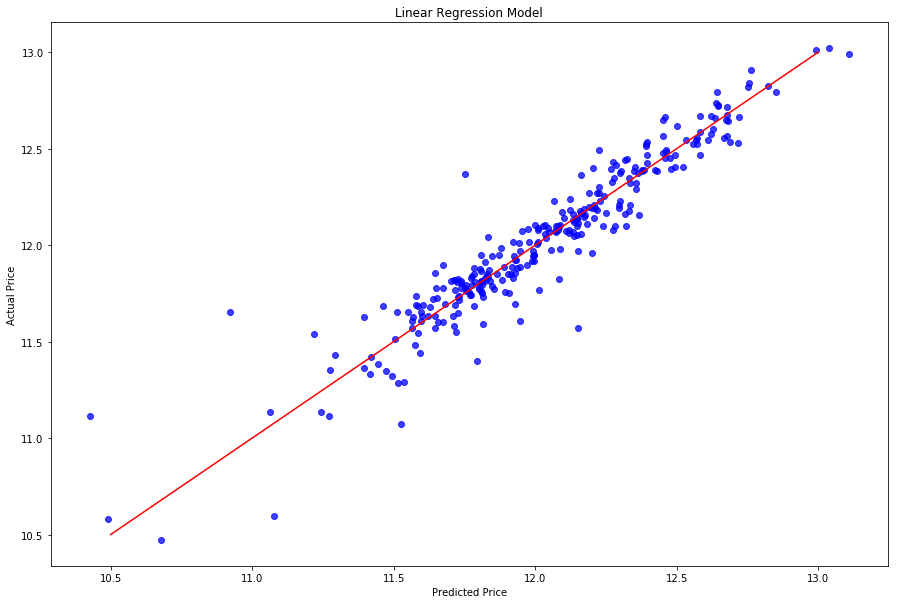

In [322]:

actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

### KernelRidge Regularization

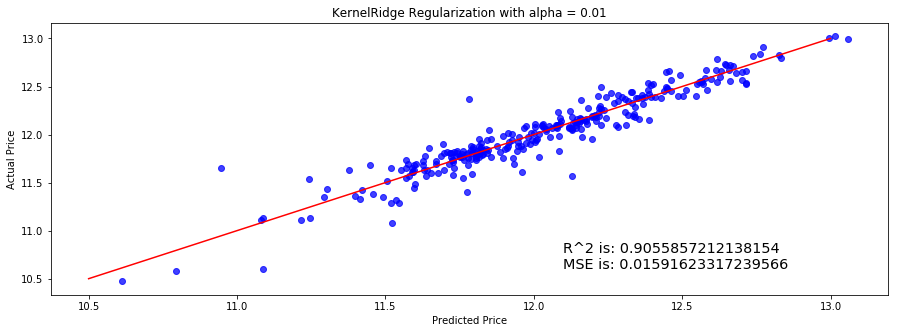

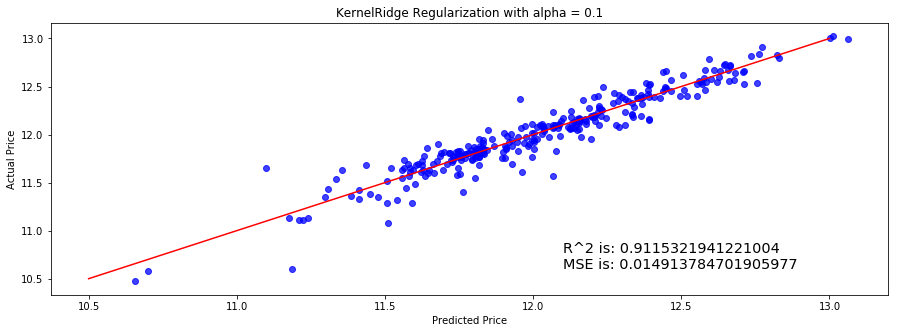

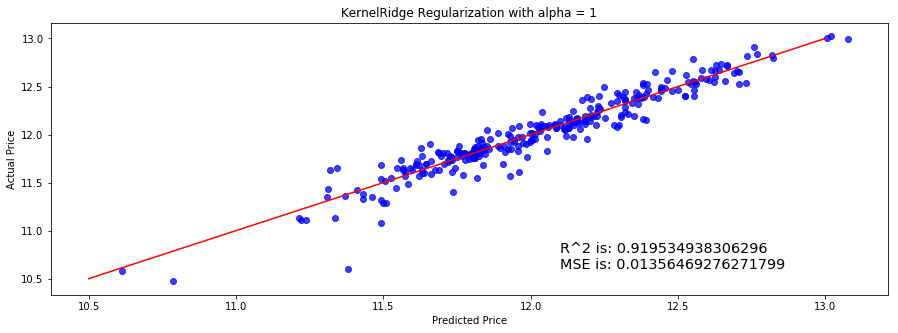

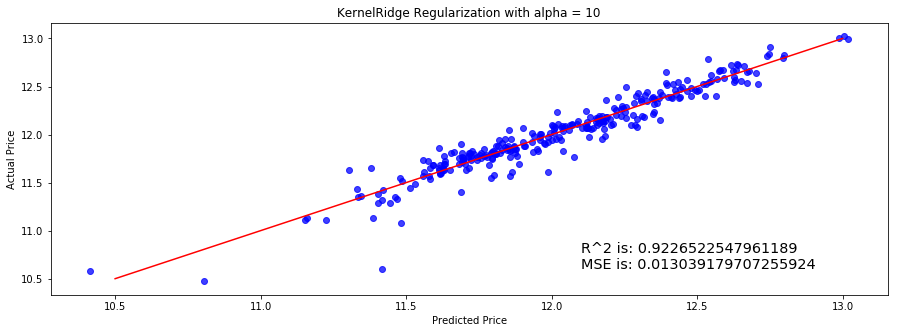

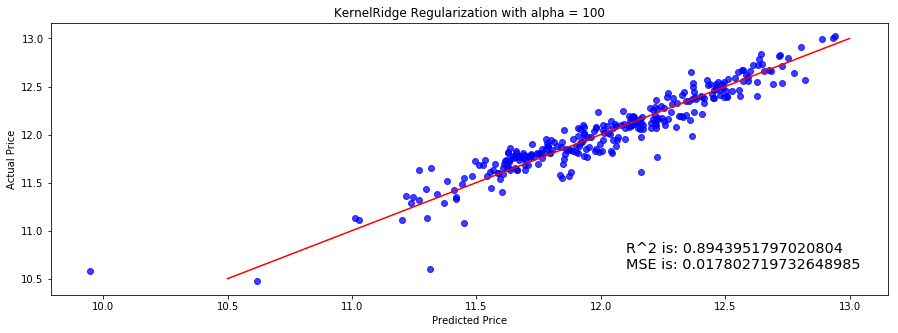

In [323]:
for alpha in [0.01,0.1,1,10,100]:
    rm = KernelRidge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)
    plt.figure(figsize=(15,5))
    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.plot([10.5,13],[10.5,13],"r")
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('KernelRidge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nMSE is: {}'.format(
                    ridge_model.score(X_test, y_test),
                    mean_squared_error(y_test, preds_ridge))
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()


## BayesianRidge

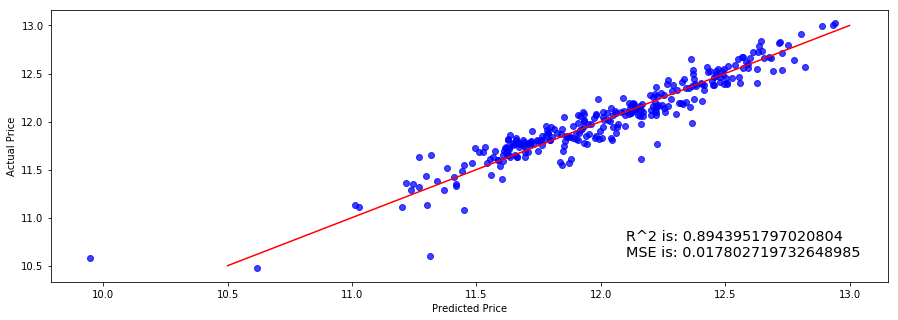

In [324]:

br = BayesianRidge(alpha_1=1e-08,alpha_2=5e-06)
bayesian_model = rm.fit(X_train, y_train)
br_preds = bayesian_model.predict(X_test)
plt.figure(figsize=(15,5))
plt.scatter(br_preds, actual_values, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')

overlay = 'R^2 is: {}\nMSE is: {}'.format(
                bayesian_model.score(X_test, y_test),
                mean_squared_error(y_test, preds_ridge))
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()


## Random Forrest

In [325]:
fr = RandomForestRegressor(n_estimators=100,random_state=42)
randomForrestModel = fr.fit(X_train, y_train)
print ("R^2 is:", randomForrestModel.score(X_test, y_test))

R^2 is: 0.8757263099186998


In [326]:
fr_preds = randomForrestModel.predict(X_test)
print ('MSE is:', mean_squared_error(y_test,fr_preds))

MSE is: 0.020949892897105308


In [327]:
scores = cross_val_score(randomForrestModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.14)


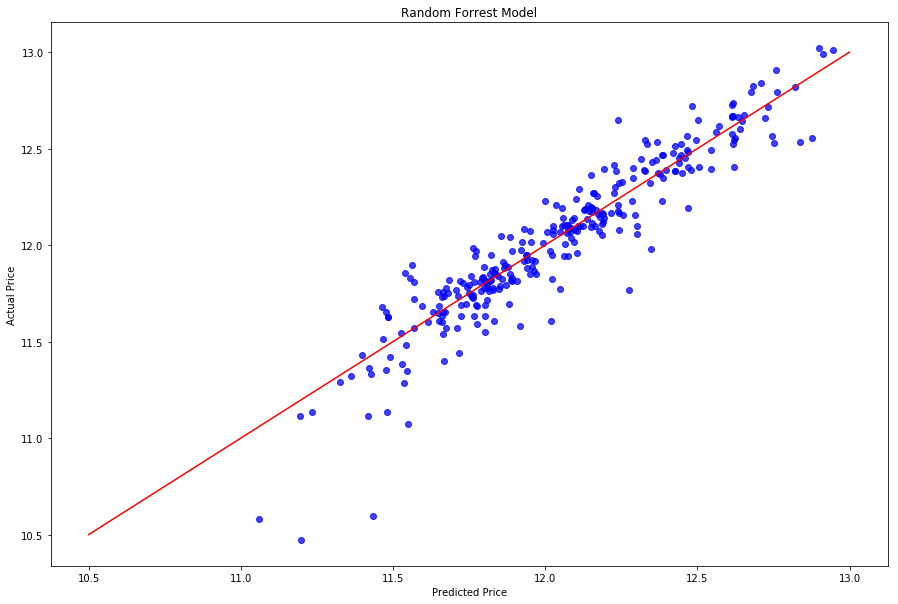

In [328]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(fr_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forrest Model')
plt.show()

## Gradient boosting

In [329]:
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2)
n_jobs=4

In [330]:
def hyperparameterTuning(estimator,param_grid, n_jobs,cv): 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print("Best Estimator learned through GridSearch")
    print(classifier.best_estimator_)
    return cv, classifier.best_estimator_

In [331]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(15,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

R^2 is: 0.9026056465268992


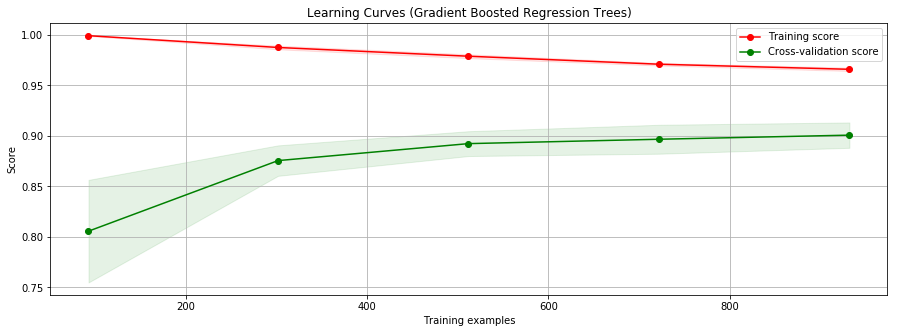

In [332]:
gb = GradientBoostingRegressor()
title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(gb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
gradientBoostingModel = gb.fit(X_train, y_train)
print ("R^2 is:", gradientBoostingModel.score(X_test, y_test))

In [333]:
predictions = gradientBoostingModel.predict(X_test)
print ('MSE is:', mean_squared_error(y_test, predictions))

MSE is: 0.01641861018779953


In [334]:
scores = cross_val_score(gradientBoostingModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.11)


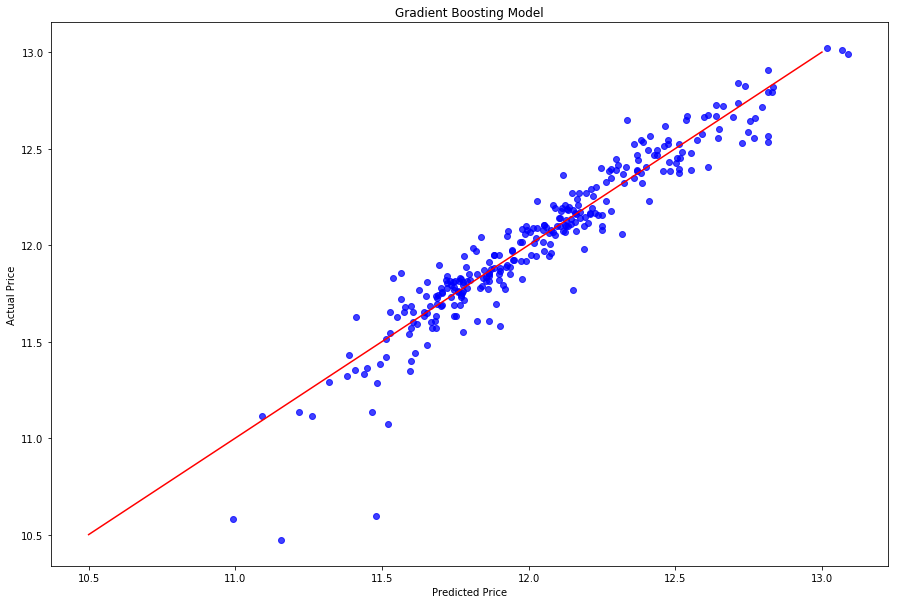

In [335]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

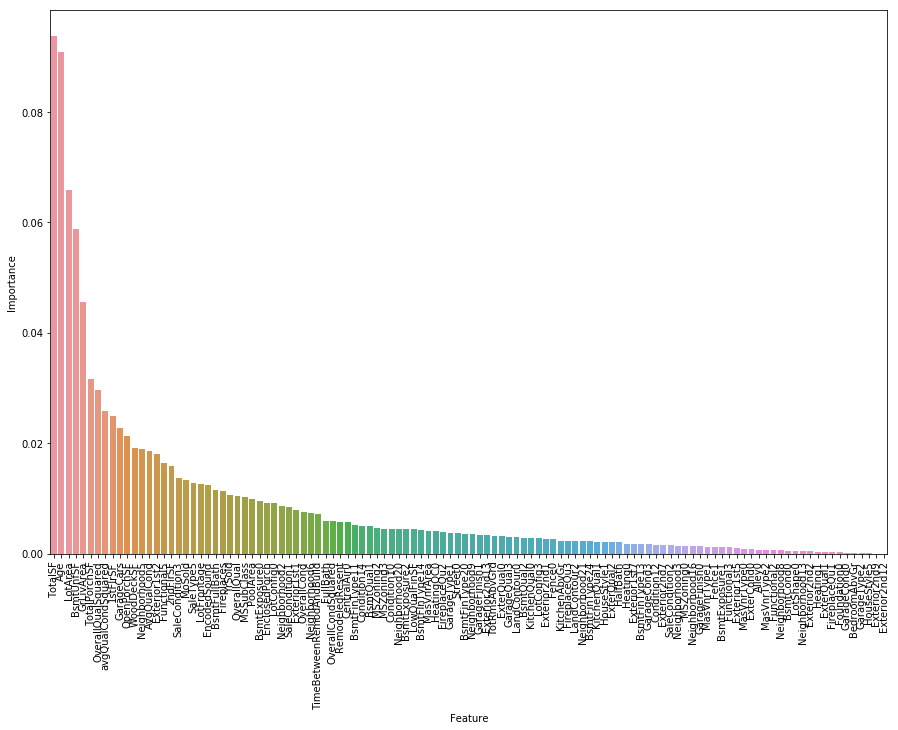

In [336]:
importances = gb.feature_importances_
columns = X_test.columns.values


feature_importance = list(zip(columns,importances))
sorted_feature_importance = np.array(sorted(feature_importance,key=lambda x : x[1],reverse=True))
sorted_feature_importance = list(map(lambda x : [x[0],float(x[1])],sorted_feature_importance))


featureImportanceDF = pd.DataFrame(data=sorted_feature_importance,columns=["Feature","Importance"]).query("Importance > 0")
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Feature", y="Importance",data=featureImportanceDF)

### Improving Gradient Boosting

In [337]:
param_grid={'n_estimators':[100],
            'learning_rate': [0.1],
            'max_depth':[6],
            'min_samples_leaf':[3],
            'max_features':[1.0],
           }

estimator = GradientBoostingRegressor()
cv,best_est = hyperparameterTuning(estimator,param_grid, n_jobs,cv)

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=1.0,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


<module 'matplotlib.pyplot' from '/home/marius/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

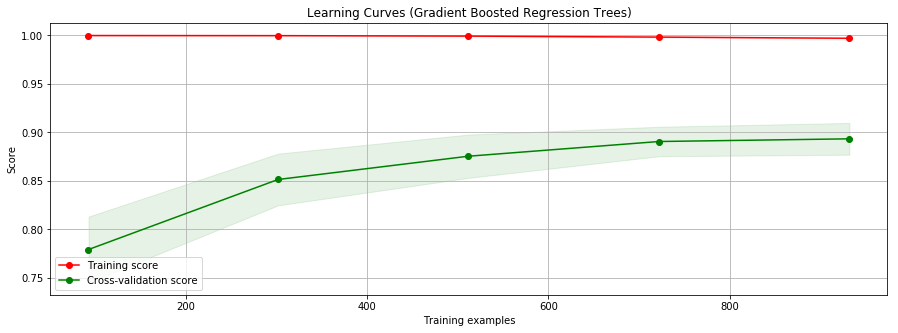

In [338]:
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
            learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
            max_features=best_est.max_features)
title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [339]:
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)
print ('MSE is:', mean_squared_error(y_test, predictions))

MSE is: 0.018455095881372598


In [340]:
param_grid={'n_estimators':[100,500,1000,2000],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6],
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }
n_jobs=4
#cv,best_est=GradientBooster(param_grid, n_jobs)

try:
    best_est = pickle.load( open( "GradientBoostingBestEstimator.p", "rb" ) )
    None
except:
    cv,best_est = hyperparameterTuning(param_grid, n_jobs)
    None



In [341]:
pickle.dump(best_est, open( "GradientBoostingBestEstimator.p", "wb" ) )


<module 'matplotlib.pyplot' from '/home/marius/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

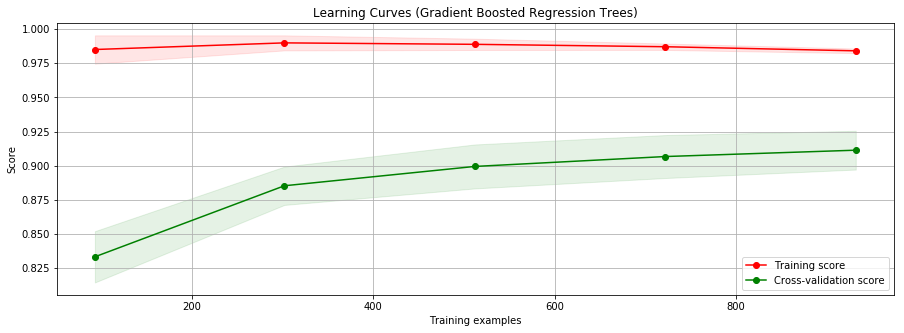

In [342]:
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
            learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
            max_features=best_est.max_features,loss="huber",random_state=5)

title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)


In [343]:
estimator.fit(X_train, y_train)
gb_preds = estimator.predict(X_test)
print ("R^2 is:", estimator.score(X_test, y_test))
print ('MSE is:', mean_squared_error(y_test, gb_preds))

R^2 is: 0.9094670110186263
MSE is: 0.015261930514606888


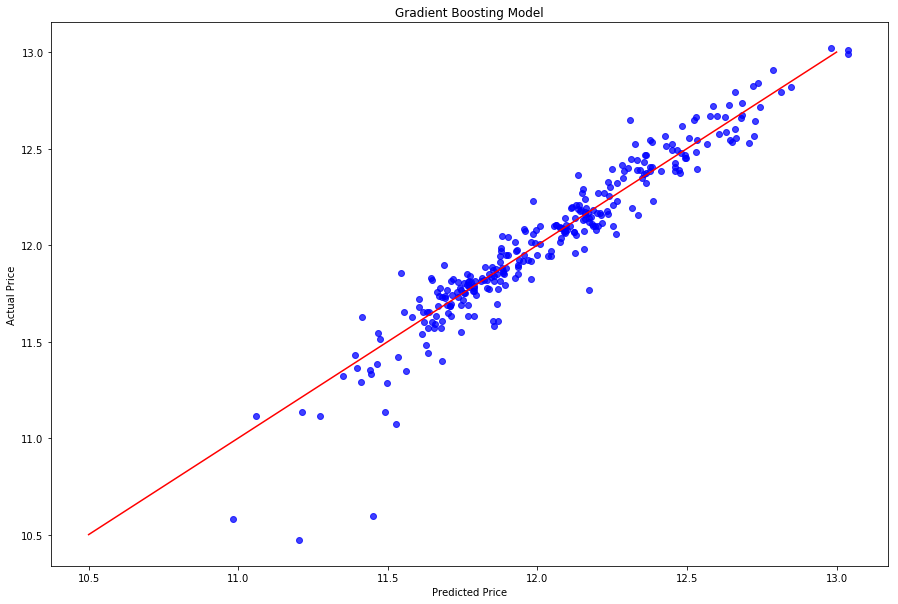

In [344]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(gb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

### Using XGBoost 

In [345]:
param_grid={'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6,8,10],
            'gamma ':[0.01,0.04,0.08,0.12,0.5], 
            'subsample':[0.5,0.75,1],
            'colsample_bytree ':[0.5,0.75,1],
            'alpha':[0.001,0.01,0.1,1],
            'n_estimators':[1000,2000,3000]
           }
try:
    best_est = pickle.load( open( "XGBoostBestEstimator.p", "rb" ) )
    
except:
    #cv,best_est = hyperparameterTuning(param_grid, n_jobs)
    None

In [346]:
#pickle.dump(best_est, open( "XGBoostBestEstimator.p", "wb" ) )

In [347]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

title = "Learning Curves (XGBoost Regression Trees)"
#plot_learning_curve(model_xgb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [348]:
model_xgb.fit(X_train, y_train)
xgb_preds = model_xgb.predict(X_test)

print ("R^2 is:", model_xgb.score(X_test, y_test))
print ('MSE is:', mean_squared_error(y_test, xgb_preds))

R^2 is: 0.9116965446774188
MSE is: 0.014886078704528362


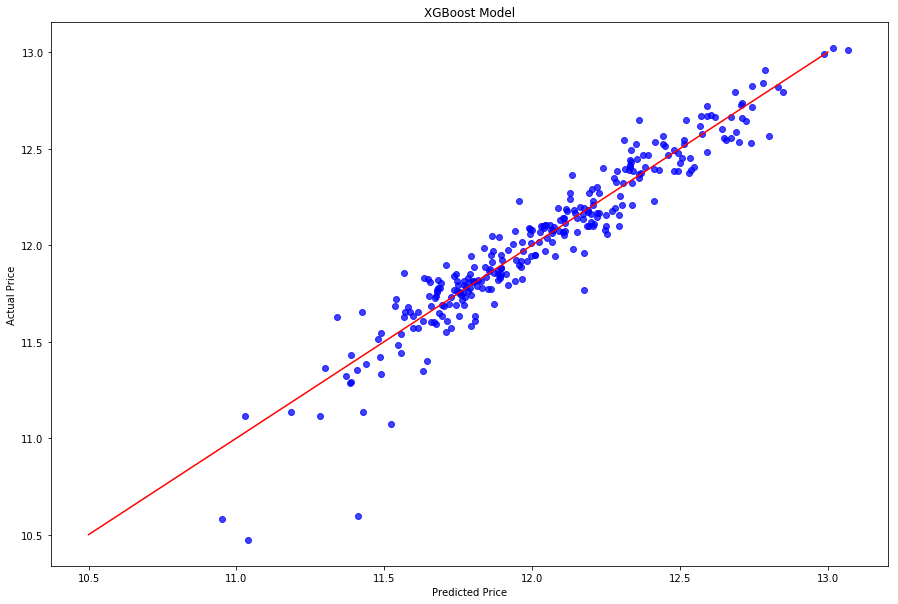

In [349]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(xgb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Model')
plt.show()

### Using LightGBM

In [350]:
param_grid={'n_estimators':[100,500,1000,2000],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6],
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }
try:
    best_est = pickle.load( open( "LightGBMBestEstimator.p", "rb" ) )
except:
    #cv,best_est = hyperparameterTuning(param_grid, n_jobs)
    None

In [351]:
#pickle.dump(best_est, open( "LightGBMBestEstimator.p", "wb" ) )

In [352]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
title = "Learning Curves (LightGBM Regression Trees)"
#plot_learning_curve(model_lgb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [353]:
model_lgb.fit(X_train, y_train)
lgb_preds = model_lgb.predict(X_test)

print ("R^2 is:", model_lgb.score(X_test, y_test))
print ('MSE is:', mean_squared_error(y_test, lgb_preds))

R^2 is: 0.9123625119344072
MSE is: 0.014773810832722521


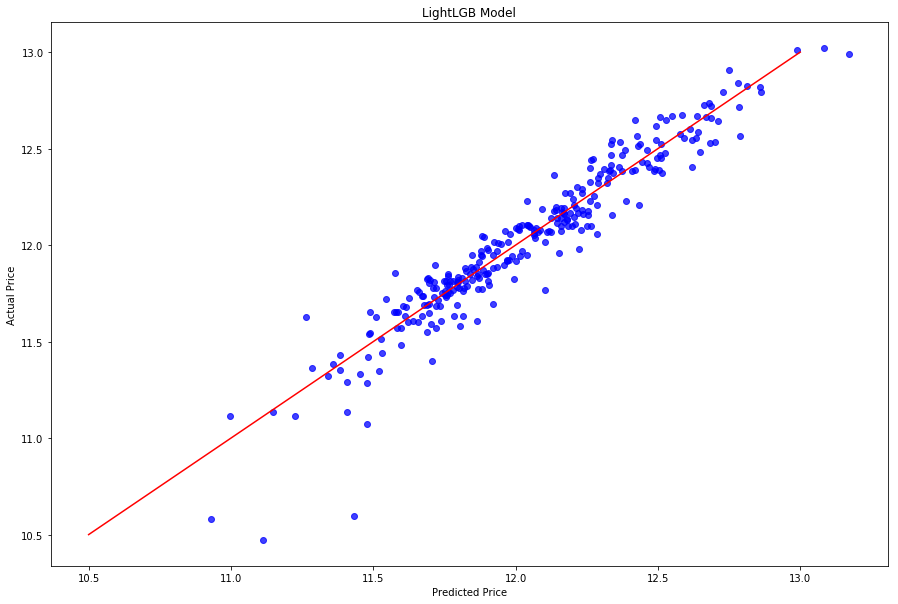

In [354]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(lgb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('LightLGB Model')
plt.show()

# Using Lasso as a Meta-model

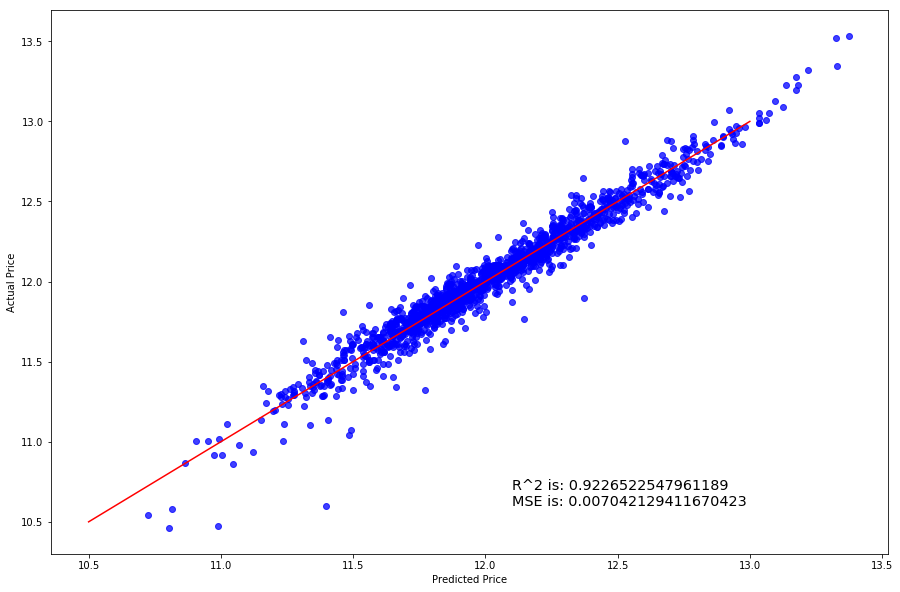

In [355]:
rm = KernelRidge(alpha=10)
ridge_model = rm.fit(X_train, y_train)
rm_preds = ridge_model.predict(X_test)

lgb_test_preds = model_lgb.predict(X)
xgb_test_preds = model_xgb.predict(X)
gb_test_preds = estimator.predict(X)
rm_test_preds = ridge_model.predict(X)

all_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds]).T
all_test_preds = np.array([lgb_test_preds,xgb_test_preds,gb_test_preds,rm_test_preds]).T

lm = Lasso(alpha=0.001)
lasso_model = lm.fit(all_preds, y_test)
meta_preds = lasso_model.predict(all_test_preds)
plt.figure(figsize=(15,10))
plt.scatter(meta_preds, y, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
overlay = 'R^2 is: {}\nMSE is: {}'.format(
                ridge_model.score(X_test, y_test),
                mean_squared_error(y, meta_preds))
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()

# Capturing large errors

In [356]:

errorDF = pd.DataFrame(data=y_test)
errorDF["Prediction"] = lgb_preds

res = errorDF.query("SalePrice < 11 & Prediction < 11.5")

outliersDF = pd.DataFrame()
outliersDF["SalePrice"] = np.exp(res.SalePrice.values)
outliersDF["Prediction"] = np.exp(res.Prediction.values)
outliersDF.index = res.index
print(outliersDF)

     SalePrice    Prediction
Id                          
534    39300.0  55841.864930
917    35311.0  67070.710535
31     40000.0  92168.828678


In [357]:
worstPredictions = houseDataDF.query("Id == 31 | Id == 917 | Id == 534")
columns = np.concatenate((highestCorrFeatures,["Neighborhood"]))
worstPredictions[columns]

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,Neighborhood
Id,,,,,,,,,,,
31,4,1317,1,250,649,649,1,6,1920,1950,IDOTRR
534,1,334,0,0,0,334,1,2,1946,1950,BrkSide
917,2,480,1,308,480,480,0,4,1949,1950,IDOTRR


# Create submission

In [358]:
lgb_preds = model_lgb.predict(testData)
xgb_preds = model_xgb.predict(testData)
gb_preds = estimator.predict(testData)
rm_preds = ridge_model.predict(testData)

all_model_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds]).T

final_predictions = np.exp(lasso_model.predict(all_model_preds))

submission = pd.DataFrame()
submission['Id'] = idColl
submission['SalePrice'] = final_predictions
submission.head(20)

,Id,SalePrice
0,1461,114008.910873
1,1462,155641.764638
2,1463,185697.081343
3,1464,192305.764938
4,1465,191372.613201
5,1466,172801.305889
6,1467,174668.252572
7,1468,160018.747207
8,1469,195137.063296
9,1470,117664.278207


In [359]:

ansDF = pd.read_csv(base + "train2.csv")
idColl = ansDF.Id
ansDF = ansDF.drop(["Id"],axis=1)
ansDF.index = idColl
ansDF = pd.DataFrame(ansDF.SalePrice[1200:])
ansDF["Predicted"] = submission.SalePrice.values
ansDF.head(20)
#diff = np.sum(np.log(np.square((np.array(ansDF.values) - np.array(submission.SalePrice.values)))))


ValueError: Length of values does not match length of index

In [ ]:
print("Mean squared log error:")
print(mean_squared_log_error(ansDF["SalePrice"],ansDF["Predicted"]))

In [360]:
submission.to_csv('submission1.csv', index=False)